<a href="https://colab.research.google.com/github/spade0211/Simulation-of-Steel-Rod-Heating-and-Temperature-Distribution-Visualization/blob/main/Number_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loads the MNIST dataset to the 'data' directory

In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

100%|██████████| 9912422/9912422 [00:00<00:00, 86540522.43it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38273520.96it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26077235.21it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10830317.66it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Retrieves an image and its corresponding label from the MNIST dataset, and then prints out the label and a subset of the image tensor

In [ ]:
img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

Takes in a tensor x and applies a de-normalization process to it

In [ ]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Displays an image from the MNIST dataset, after denormalizing it using the denorm() function defined earlier

Label: 5


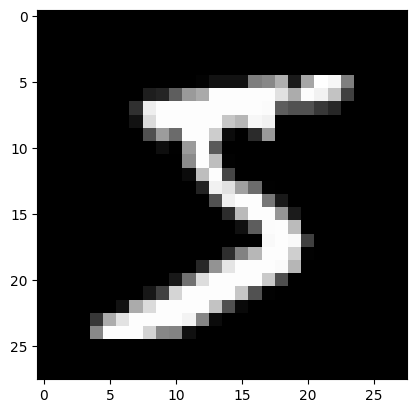

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

Initializes a DataLoader object that can be used to load the MNIST dataset in batches during training

In [ ]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

Uses the data_loader object to iterate over the data in batches

first batch
torch.Size([100, 1, 28, 28])
tensor([0, 9, 6, 6, 9, 1, 6, 7, 1, 4, 0, 6, 0, 6, 0, 1, 3, 7, 3, 2, 6, 3, 4, 2,
        8, 3, 4, 0, 4, 1, 5, 3, 7, 7, 5, 5, 5, 7, 6, 3, 7, 3, 3, 5, 8, 0, 6, 8,
        2, 7, 5, 2, 0, 7, 1, 1, 2, 8, 1, 3, 7, 6, 6, 0, 2, 0, 5, 7, 1, 8, 2, 0,
        2, 9, 1, 2, 1, 0, 5, 5, 8, 1, 1, 2, 8, 4, 4, 1, 4, 7, 4, 8, 6, 1, 8, 3,
        7, 0, 9, 3])


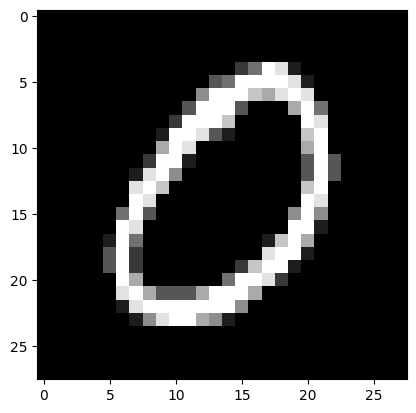

In [ ]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

Define the image_size and hidden_size variables which will be used in the neural network architecture later on.

In [ ]:
image_size = 784
hidden_size = 256

Defines a discriminator neural network using the PyTorch nn.Sequential module. The discriminator takes in an image of size image_size (in this case, 784) and outputs a single value between 0 and 1, representing the probability that the input image is real (as opposed to generated by the generator).

The discriminator has three linear layers (fully connected layers), with the first two having a hidden size of hidden_size (in this case, 256) and the last one having an output size of 1. In between the linear layers, there are two LeakyReLU activation functions, with a negative slope of 0.2. The last layer uses a sigmoid activation function to squash the output to a probability value between 0 and 1.

In [ ]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [ ]:
D.to(device);

Latent_size is a variable used to specify the dimensionality of the random noise vector that will be used as input to the generator in a GAN.

In [ ]:
latent_size = 64

Defines a generator neural network. It is a fully connected neural network with three layers. The first layer takes a random noise vector of size latent_size as input and outputs a hidden representation of size hidden_size. The output of the first layer is then passed through two more fully connected layers with ReLU activation functions. Finally, the output of the last layer is passed through a hyperbolic tangent (Tanh) activation function. The output of the generator is an image with the same dimensions as the MNIST dataset (28x28).

In [ ]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

This code generates fake images using the generator network G. It first creates a tensor y of size (2, latent_size) with random values sampled from a normal distribution using torch.randn. These values are then passed through the generator network G to generate a tensor of size (2, image_size) which represents two fake images of size 28x28.

The tensor is then reshaped to (2, 28, 28) and passed through the denorm function to transform the pixel values from the range [-1, 1] back to the range [0, 1]. Finally, the detach method is used to detach the tensor from the computational graph to prevent any gradients from being computed with respect to this tensor.

In [ ]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

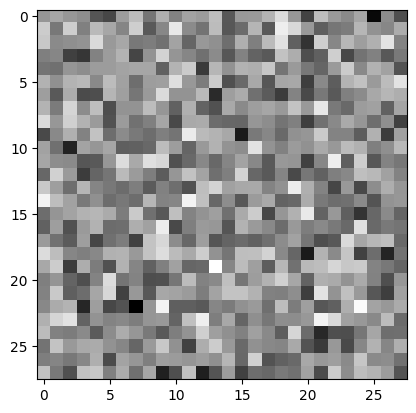

In [ ]:
plt.imshow(gen_imgs[0], cmap='gray');

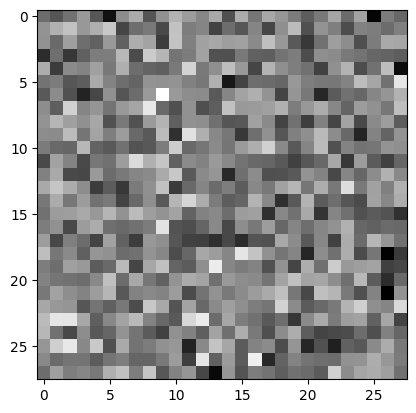

In [ ]:
plt.imshow(gen_imgs[1], cmap='gray');

In [ ]:
G.to(device);

nn.BCELoss() is used to define the binary cross entropy loss function, which is commonly used as a loss function for binary classification problems like in our discriminator network.

torch.optim.Adam(D.parameters(), lr=0.0002) creates an optimizer object that will update the parameters of the discriminator network. Here, the optimizer is Adam and it is being passed the discriminator parameters, i.e. D.parameters(), and a learning rate of 0.0002.

In [ ]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

This function trains the discriminator on a batch of real images and a batch of fake images generated by the generator. It first creates the real and fake labels as tensors of ones and zeros, respectively, and sends them to the device. Then it calculates the loss for the real images by passing them through the discriminator and comparing the output to the real labels using the BCE loss function. Similarly, it generates fake images by passing random noise through the generator, passes them through the discriminator, and calculates the loss by comparing the output to the fake labels. The two losses are then combined, and the gradients are computed and used to update the parameters of the discriminator using the Adam optimizer. Finally, it returns the total loss, as well as the scores for the real and fake images.

In [ ]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

In [ ]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [ ]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

Stores the generated samples (images) during the training process.

In [ ]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

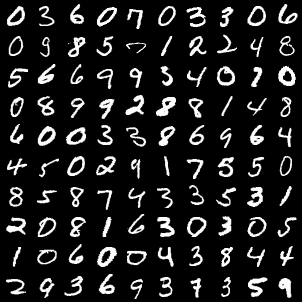

In [ ]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


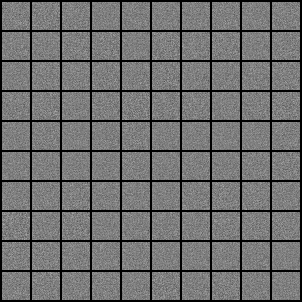

In [ ]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [ ]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0420, g_loss: 4.1072, D(x): 0.99, D(G(z)): 0.04
Epoch [0/300], Step [400/600], d_loss: 0.0592, g_loss: 6.1580, D(x): 0.97, D(G(z)): 0.03
Epoch [0/300], Step [600/600], d_loss: 0.0331, g_loss: 5.9161, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0525, g_loss: 5.5807, D(x): 0.99, D(G(z)): 0.04
Epoch [1/300], Step [400/600], d_loss: 0.6286, g_loss: 2.9105, D(x): 0.79, D(G(z)): 0.13
Epoch [1/300], Step [600/600], d_loss: 0.1831, g_loss: 6.0394, D(x): 0.94, D(G(z)): 0.08
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.3134, g_loss: 3.9705, D(x): 0.91, D(G(z)): 0.11
Epoch [2/300], Step [400/600], d_loss: 0.1021, g_loss: 4.1722, D(x): 0.97, D(G(z)): 0.07
Epoch [2/300], Step [600/600], d_loss: 0.2271, g_loss: 4.6758, D(x): 0.89, D(G(z)): 0.03
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.3809, g_loss: 2.8313, D(x): 0.86, D(G(z)): 0.16
Epoch [3/300], Step [400/6

In [ ]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

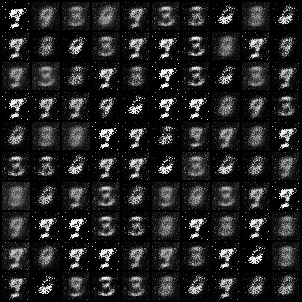

In [ ]:
Image('./samples/fake_images-0010.png')

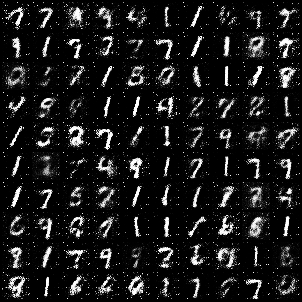

In [ ]:
Image('./samples/fake_images-0050.png')

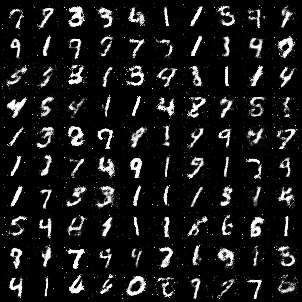

In [ ]:
Image('./samples/fake_images-0100.png')

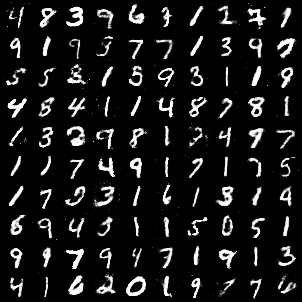

In [ ]:
Image('./samples/fake_images-0300.png')

Visualize the training process by combining the sample images generated after each epoch into a video using OpenCV

In [ ]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/content/gans_training.avi

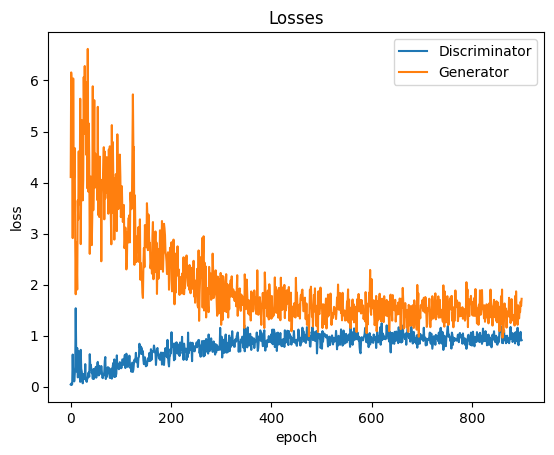

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

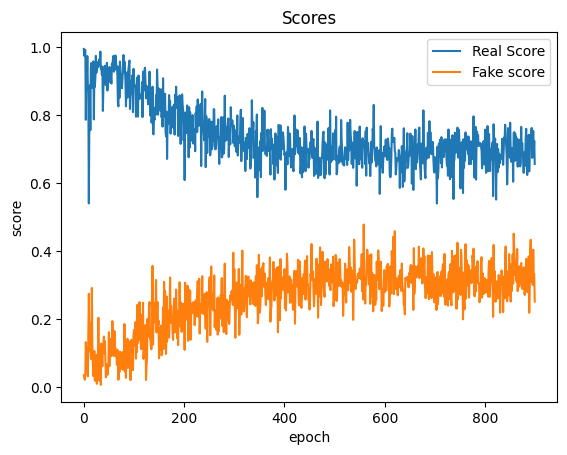

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

Indivisual testing--

In [ ]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)


In [ ]:
fake_images = G(sample_vectors)

In [ ]:
fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
save_image(denorm(fake_images), os.path.join(sample_dir, 'test.png'), nrow=10)

In [ ]:
save_image(denorm(fake_images), os.path.join(sample_dir, 'test2.png'), nrow=1)